# LeNet5 Keras MNIST (Recognizing Handwritten Digits)

In [ ]:
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import datasets
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 55MB download may take a minute)
print("[INFO] accessing MNIST...")
dataset = datasets.fetch_mldata("MNIST Original")
data = dataset.data
print('MNIST data shape: ', data.shape, data.dtype)

In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
    data = data.reshape(data.shape[0], 1, 28, 28)
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
    data = data.reshape(data.shape[0], 28, 28, 1)

In [ ]:
print('MNIST data shape: ', data.shape, data.dtype)
print('MNIST labels shape: ', dataset.target.shape, dataset.target.dtype)

In [ ]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(dataset.target == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(data[idx].astype('uint8').reshape(28, 28))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [ ]:
# scale the input data to the range [0, 1] and perform a train/test split
(trainX, testX, trainY, testY) = train_test_split(data/255.0, dataset.target.astype("int"), test_size=0.25, random_state=42)

# convert the labels from integers to vectors
labelBinarizer = LabelBinarizer()
trainY = labelBinarizer.fit_transform(trainY)
testY = labelBinarizer.fit_transform(testY)

print('Training data shape: ', trainX.shape, trainX.dtype)
print('Training labels shape: ', trainY.shape, trainY.dtype)
print('Test data shape: ', testX.shape, testX.dtype)
print('Test labels shape: ', testY.shape, testY.dtype)

In [ ]:
from classifiers.lenet5 import LeNet5

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01)
model = LeNet5().build()
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=128, epochs=20, verbose=1)

In [ ]:
model.summary()

In [12]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=[str(x) for x in labelBinarizer.classes_]))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1677
           1       0.97      0.99      0.98      1935
           2       0.99      0.96      0.98      1767
           3       0.97      0.98      0.98      1766
           4       0.97      0.99      0.98      1691
           5       0.99      0.97      0.98      1653
           6       0.98      0.99      0.99      1754
           7       0.98      0.98      0.98      1846
           8       0.97      0.97      0.97      1702
           9       0.97      0.96      0.97      1709

    accuracy                           0.98     17500
   macro avg       0.98      0.98      0.98     17500
weighted avg       0.98      0.98      0.98     17500



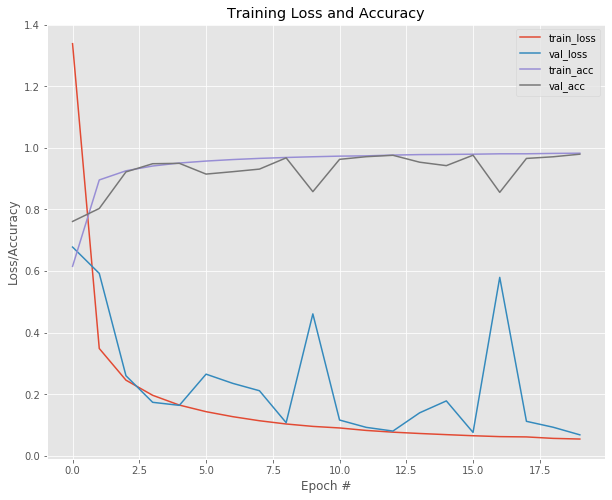

In [13]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

Well Done